In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [8]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2010")
    test = data[test_mask].cases
    return train, test

In [9]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [89]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\sigma\,(w_{i}\cdot x_{i}) = \sum_{i=0}^{n} w_{i} x_{i}$$

$$Seasonal\,Part_{0} =\,\cos^2(\dfrac{\pi}{52}\,(x - c)) + k$$

$$Seasonal\,Part_{1} =\,\sin(\dfrac{\pi}{52}\,(x - c)) + k$$

$$cases = (\sigma(w\cdot x) \,\times Seasonal\,Part) +\, k$$

In [130]:
def guess(w,x_week,y_case):
    
    def sigma(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        all_cases = np.dot(w[:-3],pad_y)
        return all_cases

    # this fails
    def season_cos_sq(w,x_week):
        pi = np.math.pi
        coeff = pi/52.
        inside = (coeff*x_week) - (coeff*w[-2])
        cosine_sq = np.math.cos(inside)**2
        score = cosine_sq + w[-3]
        return expit(score)
    
    # this works
    def season_sin(w,x_week):
        coeff = np.math.pi / 52.
        inside = coeff*(x_week - w[-2])
        score = np.math.sin(inside) + w[-3]
        return score
    
    return (sigma(w,y_case) * season_sin(w,x_week)) + w[-1]

def get_alphas(LAG,train,constant):
    W_CASE = LAG + 1
    W_POP = 1
    W_SEASON = 2
    BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

    # use poison instead of least square
    def cost(w):
        ret = 0
        for week_no in range(len(train)-W_CASE):
            real_case = train[week_no+W_CASE]
            predicted_case = guess(w,week_no,train[week_no:week_no+LAG])
            sigma_sq = real_case + 1 # assume poisson and avoid division by zero
            ret += ((real_case - predicted_case)**2)/float(sigma_sq)
        print ret
        return ret

#     pop_starter = np.log(population)
    seasonality_starters = [0,35] # [amplitude,constant,period,phase]
    arr = np.array([0.]*W_CASE) #  betas
#     arr = np.array(pd.read_csv('starter_ws.csv')['starter_ws'][:-1])
    arr = np.append(arr,seasonality_starters) # 31 betas
    arr = np.append(arr,constant) # 32 betas
    w = minimize(cost,arr)
    return w


In [131]:
trial00 = get_alphas(10,cm_dengues_train,100)

663153.588549
663153.588551
663153.588618
663153.588613
663153.588598
663153.588557
663153.588528
663153.588512
663153.588493
663153.588474
663153.588455
663153.588441
663153.588549
663153.588549
663153.588751
663153.588549
651166.08867
651166.08867
651166.088675
651166.088779
651166.088793
651166.088801
651166.088784
651166.088779
651166.088787
651166.088789
651166.088788
651166.088784
651166.088779
651166.088468
651166.088659
651166.08887
604975.168135
604975.168135
604975.168185
604975.16842
604975.168379
604975.168355
604975.168338
604975.168335
604975.168356
604975.168388
604975.168418
604975.16844
604975.168462
604975.16703
604975.16819
604975.168324
6340886.36789
6340886.36789
6340886.36783
6340886.33555
6340886.33851
6340886.34217
6340886.34618
6340886.34944
6340886.35317
6340886.35673
6340886.35976
6340886.36218
6340886.3642
6340886.50268
6340886.37475
6340886.36786
597820.765482
597820.765482
597820.765547
597820.765411
597820.765385
597820.765396
597820.765431
597820.765471


In [132]:
trial00.x

array([ -3.85288676e-01,   5.62262526e-03,  -2.02931949e-03,
         3.35185687e-03,  -7.71490617e-03,  -1.25049015e-02,
        -1.27379204e-02,  -7.68318577e-03,   1.29015479e-02,
         2.19547134e-02,   1.01796923e-01,   8.24910981e+00,
         2.64805033e+01,   3.15094778e+00])

In [128]:
# nweek_to_predict = [1,2,4,8,12]

def plot_prediction(LAG,real,ws,nweek_to_predict=[1,2,4]):

    NWEEKS = LAG
    def n_week_ahead(array_x,weeks_ahead):

        theta = 0
        arr = np.array(array_x)
        for week_no in range(weeks_ahead):
            theta = guess(ws,week_no,arr)
            arr = np.append(arr[1:],theta)
        return theta

    for i in nweek_to_predict:
        N = NWEEKS + (i - 1)
        predictions = []
        for j in range(len(real)-N):
            initial_arr = real[j:j+NWEEKS]
            predictions.append(n_week_ahead(initial_arr,i))
#         return predictions

        title = 'Dengue Prediction %d lags: %d weeks ahead'%(NWEEKS,i)
        make_line(NWEEKS+i,real,predictions,title,"# week starting 2011","cases")

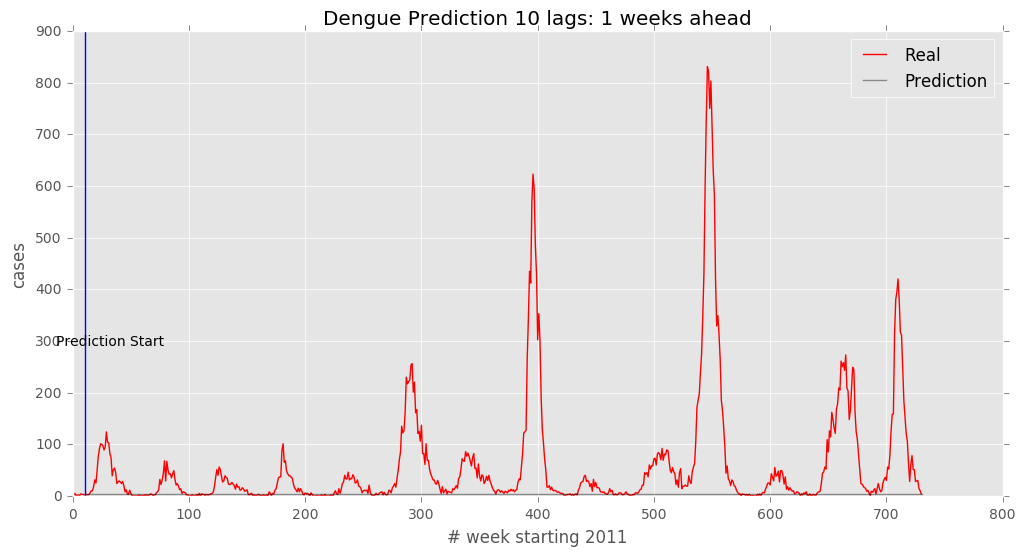

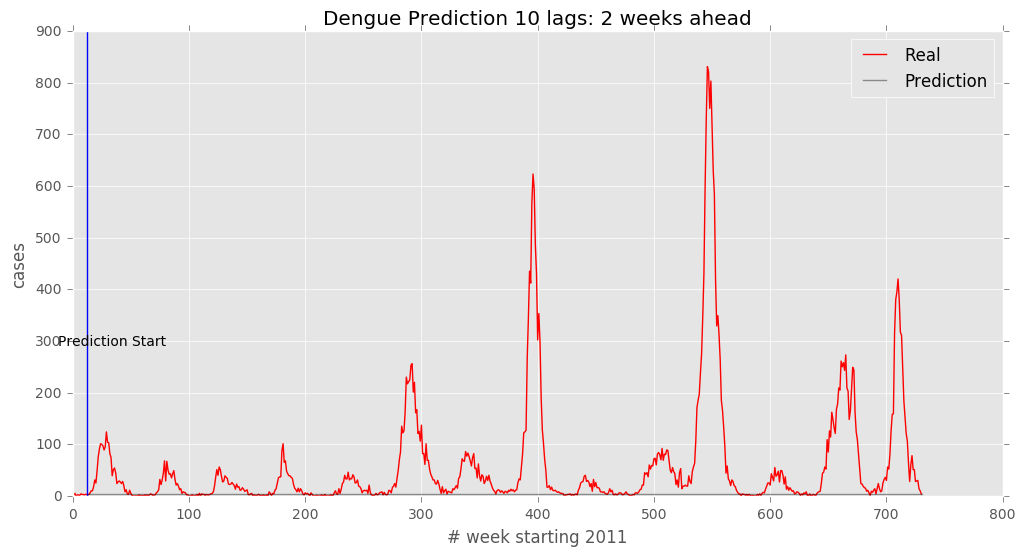

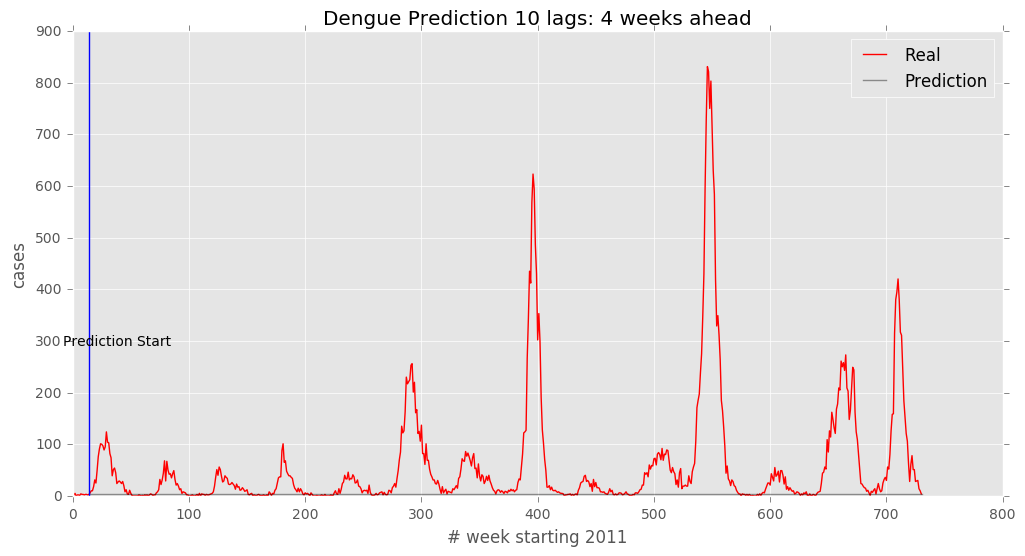

In [129]:
plot_prediction(10,cm_dengues_df.cases,trial00.x)

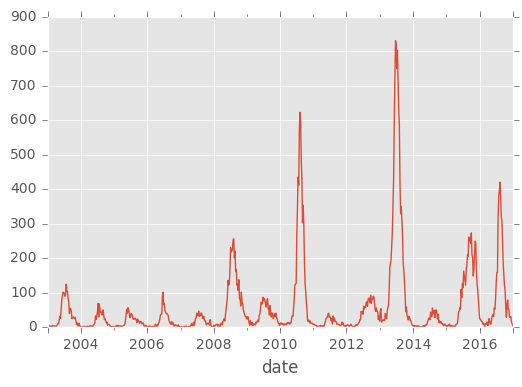

In [50]:
cm_dengues_df.cases.plot()

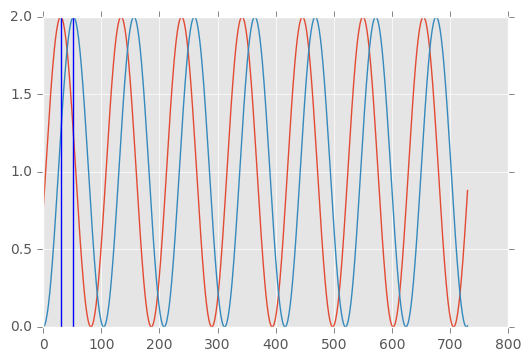

In [141]:
def cos_sq(x,const):
    coeff = np.math.pi / 52.
    inside = coeff*(x - const)
    return (np.math.cos(inside)**2)

def sine(x,const):
    coeff = np.math.pi / 52.
    inside = coeff*(x - const)
    return np.math.sin(inside) + 1

ixs = range(len(xs))
ys4 = [sine(i,4) for i in ixs] # (52/2) + 4 = 30
ys26 = [sine(i,26) for i in ixs] # (52/2) + 4 = 30
ys_sq = [cos_sq(i,30) for i in ixs]
plt.plot(ixs,ys4)
plt.plot(ixs,ys26)
# plt.plot(ixs,ys_sq)
plt.axvline(30)
plt.axvline(52)